In [27]:
import tensorflow as tf
%load_ext tensorboard

In [8]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import datetime

In [9]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  if image.shape[-1] == 1:
    image = tf.squeeze(image, axis=-1)

  plt.imshow(image)
  if title:
    plt.title(title)

In [10]:
image_paths = {'ballon': ['https://raw.githubusercontent.com/luanfujun/deep-painterly-harmonization/master/data/0_c_mask_dilated.jpg',
                        'https://raw.githubusercontent.com/luanfujun/deep-painterly-harmonization/master/data/0_naive.jpg',
                        'https://raw.githubusercontent.com/luanfujun/deep-painterly-harmonization/master/data/0_target.jpg',
                        'https://github.com/luanfujun/deep-painterly-harmonization/blob/master/results/0_inter_res.jpg?raw=true'],
               
               'mrbean': ['https://github.com/luanfujun/deep-painterly-harmonization/blob/master/data/17_c_mask_dilated.jpg?raw=true',
                          'https://github.com/luanfujun/deep-painterly-harmonization/blob/master/data/17_naive.jpg?raw=true',
                          'https://github.com/luanfujun/deep-painterly-harmonization/blob/master/data/17_target.jpg?raw=true',
                          'https://github.com/luanfujun/deep-painterly-harmonization/blob/master/results/17_inter_res.jpg?raw=true']}

In [11]:
IMAGE_SET = 'ballon'

207476/207476 [==============================] - 0s 1us/step


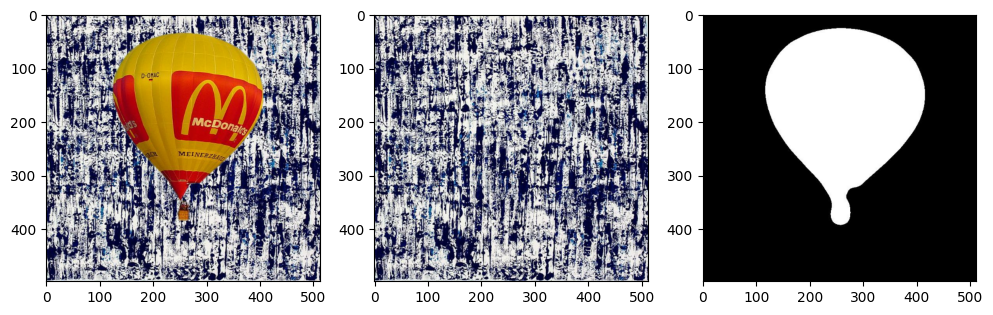

In [12]:
mask_path = tf.keras.utils.get_file(IMAGE_SET + 'mask.jpg', image_paths[IMAGE_SET][0])

input_image_path = tf.keras.utils.get_file(IMAGE_SET + 'input.jpg', image_paths[IMAGE_SET][1])

style_path = tf.keras.utils.get_file(IMAGE_SET + 'style.jpg', image_paths[IMAGE_SET][2])

intermediate_official_path = tf.keras.utils.get_file(IMAGE_SET + 'intermediate_official.jpg', image_paths[IMAGE_SET][3])

input_image = load_img(input_image_path)
style_image = load_img(style_path)
mask_image = load_img(mask_path)

plt.subplot(1, 3, 1)
imshow(input_image)

plt.subplot(1, 3, 2)
imshow(style_image)


plt.subplot(1, 3, 3)
imshow(mask_image)

In [13]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model
     

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)
     

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers, hist_layers=[], ref_layer=None):
    super(StyleContentModel, self).__init__()
    ref_layers = []
    if ref_layer:
      ref_layers.append(ref_layer)
    self.vgg =  vgg_layers(style_layers + content_layers + hist_layers + ref_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.hist_layers = hist_layers
    self.ref_layers = ref_layers
    self.num_style_layers = len(style_layers)
    self.num_hist_layers = len(hist_layers)
    self.vgg.trainable = False

  def call(self, inputs, gramatize_style=False):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    
    style_outputs = outputs[:self.num_style_layers]
    content_outputs = outputs[self.num_style_layers:-(self.num_hist_layers+1)]
    hist_outputs = outputs[-(self.num_hist_layers+1):-1]
    ref_outputs = outputs[-1:]

    if gramatize_style:
      style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]
                     
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    hist_dict = {hist_name:value
                 for hist_name, value
                 in zip(self.hist_layers, hist_outputs)}

    ref_dict = {ref_name:value
                for ref_name, value
                in zip(self.ref_layers, ref_outputs)}
    
    return {'content_layers':content_dict, 
            'style_layers':style_dict, 
            'hist_layers':hist_dict,
            'ref_layers':ref_dict}
     

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
     

def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)
     

def style_content_loss(outputs):
    style_outputs = outputs['style_layers']
    content_outputs = outputs['content_layers']

    # Calculate style loss
    style_loss = []
    for i, name in enumerate(style_outputs.keys()):
      layer_loss = tf.reduce_mean((style_outputs[name]-style_targets[name])**2)

      style_layers_tensorboard[name]['metric'](layer_loss)
      style_loss.append(layer_loss)
    style_loss = tf.add_n(style_loss)   
    style_loss *= style_weight / num_style_layers

    
    # Calculate content loss
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    

    loss = style_loss + content_loss
    
    # Write in metrics
    style_loss_metric(style_loss)
    content_loss_metric(content_loss)

    return loss

In [14]:
#@title Our config

content_layers = ['block5_conv2'] 

# Style layers of interest
style_layers = ['block2_conv1',
                'block4_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# For consistent mapping
reference_layer = 'block4_conv1'

# For histogram loss
hist_layers = ['block1_conv1', 'block4_conv1']
num_hist_layers = len(hist_layers)

     

#@title Config from paper
"""
## FROM PAPER doesnt give good results but is way faster
## ONly useful for debugging
# Content layer where will pull our feature maps
content_layers = ['block4_conv1'] 

# Style layer of interest
style_layers = ['block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# For consistent mapping
reference_layer = 'block4_conv1'

# For histogram loss
hist_layers = ['block1_conv1', 'block4_conv1']
num_hist_layers = len(hist_layers)
"""

"\n## FROM PAPER doesnt give good results but is way faster\n## ONly useful for debugging\n# Content layer where will pull our feature maps\ncontent_layers = ['block4_conv1'] \n\n# Style layer of interest\nstyle_layers = ['block3_conv1', \n                'block4_conv1', \n                'block5_conv1']\n\nnum_content_layers = len(content_layers)\nnum_style_layers = len(style_layers)\n\n# For consistent mapping\nreference_layer = 'block4_conv1'\n\n# For histogram loss\nhist_layers = ['block1_conv1', 'block4_conv1']\nnum_hist_layers = len(hist_layers)\n"

In [38]:
epochs = 10
steps_per_epoch = 100
     

#Initialize the optimizer
opt = tf.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
     

# Patch size, has to be uneven!
PATCH_SIZE = 3
P = int(PATCH_SIZE/2)

In [16]:
# Intialize neural network
x = tf.keras.applications.vgg19.preprocess_input(input_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
neural_activation_model = StyleContentModel(style_layers, 
                                            content_layers, 
                                            hist_layers,
                                            reference_layer)

80134624/80134624 [==============================] - 43s 1us/step


In [17]:
# Define our metrics
whole_loss_metric = tf.keras.metrics.Mean('whole_loss', dtype=tf.float32)
style_loss_metric = tf.keras.metrics.Mean('style_loss', dtype=tf.float32)
content_loss_metric = tf.keras.metrics.Mean('content_loss', dtype=tf.float32)
tv_loss_metric = tf.keras.metrics.Mean('tv_loss', dtype=tf.float32)

# Making metrics for each style layer
style_layers_tensorboard = {}
for layer_name in style_layers:
  metric = tf.keras.metrics.Mean(str(layer_name), dtype = tf.float32)
  style_layers_tensorboard[layer_name] = {'metric': metric}
     

PASS = "first_pass"
current_time = datetime.datetime.now().strftime("%m%d-%H%M%S")

# Summary writers
style_log_dir = 'logs/first_pass/'+ current_time + str(IMAGE_SET)  + PASS+ '/style_loss'
tv_log_dir = 'logs/first_pass/'+ current_time + str(IMAGE_SET)  + PASS+ '/tv_loss'
content_log_dir = 'logs/first_pass/'+ current_time + str(IMAGE_SET)  + PASS+ '/content_loss'
whole_loss_log_dir = 'logs/first_pass/'+ current_time + str(IMAGE_SET)  + PASS+ '/whole_loss'

style_summary_writer = tf.summary.create_file_writer(style_log_dir)
tv_summary_writer = tf.summary.create_file_writer(tv_log_dir)
content_summary_writer = tf.summary.create_file_writer(content_log_dir)
whole_loss_summary_writer = tf.summary.create_file_writer(whole_loss_log_dir)

# Making summary writer for each style layer
for layer_name in style_layers:
  log_dir = 'logs/first_pass/'+ current_time + str(IMAGE_SET)  + PASS + '/style_loss_of_' + str(layer_name)
  summary_writer = tf.summary.create_file_writer(log_dir)
  style_layers_tensorboard[layer_name]['summary_writer'] = summary_writer

In [18]:
def independent_mapping(input_image_neural_activations, mask, style_neural_activations):
  
  layers = input_image_neural_activations.keys()
  nearest_neighbor_style_mapped = {}
  nearest_neighbor_distance = {}

  # Iterate through layers
  for layer_name in layers:

    print("Independent mapping: processing " + layer_name)
    
    # both have shape:  (1, height, width, number_of_feature_maps Nl)
    input_image_layer_activation = input_image_neural_activations[layer_name]
    style_layer_activation = style_neural_activations[layer_name]
    
    # Initialize default nearest_neighbor_style
    nearest_neighbor_style_mapped[layer_name] = np.copy(style_layer_activation)

    # Intitialize nearest_neighbors distance
    # Only used for tensorboard
    nearest_neighbor_distance[layer_name] = np.zeros(shape=(input_image_layer_activation.shape[:3] + (1,)), dtype=np.float32)
    current_nearest_neighbor_distance = nearest_neighbor_distance[layer_name] #TECHNICALLY

    # Size of feature map
    height = input_image_layer_activation.shape[1]
    width =input_image_layer_activation.shape[2]
    
    # Trim style_layer_activation so that its shape is divisilbe without rest for PATCH_SIZE
    #TECHNICALLY
    trimmed_height = height - (height%PATCH_SIZE)
    trimmed_width  = width - (width%PATCH_SIZE)
    style_layer_activation = style_layer_activation[:,:trimmed_height, :trimmed_width, :] 

    # Resize the mask to the feature map
    mask = tf.image.resize(mask, (height, width))
    mask = np.around(mask)
    
    # Iterate through input_image
    for i in range(height):
      for j in range(width):

        # Check if the feature is inside mask
        if mask[0,i,j,0]:
          
          print(".", end="")

          #TODO CONSIDER PADDING
          # 3x3 patch arround the center
          input_patch = input_image_layer_activation[:, i-P:i+P+1, j-P:j+P+1, :]
          
          nn_index, distance = find_nearest_neighbor(input_patch, style_layer_activation, return_distance=True)
          current_nearest_neighbor_distance[:,i,j,:] = [distance]

          nn_i = nn_index[1]*PATCH_SIZE + P
          nn_j = nn_index[2]*PATCH_SIZE + P
          nearest_neighbor_style_mapped[layer_name][:,i,j,:] = style_layer_activation[:,nn_i,nn_j,:]
    print(".")

  return nearest_neighbor_style_mapped, nearest_neighbor_distance
     

# default initialization! reinitialize before method call using s1!
nn_used_indices = []
def find_nearest_neighbor(input_patch, style_layer_activation, return_distance=False, s1=False):
  """
  if s1 is true, nn_used_indices must be defined (nn_used_indices =  [])
  """
  """
  This function gives the nearest neighbor of the input_patch 
  inside the stlye_layer_activaiton back.
  The code of this function is not very readable, since it is optimized for being fast.
  Here is the readable version of what it does but with stride 1 instead of stride PATCH_SIZE
          
          # Initialize default values
          nearest_distance = float("inf")
          nearest_neighbor_style_patch = []

          # Find nearest neighbor
          # Iterate through style
          for k in range(1,height-1):
            for l in range(1, width-1):

              style_patch = style_layer_activation[:, i-1:i+2, j-1:j+2, :]
              
              # Caculate the distance between both patches
              distance = tf.math.reduce_sum((input_patch - style_patch)**2)

              # Transforms tensor into float
              distance = tf.keras.backend.eval(distance)

              if(distance < nearest_distance):
                nearest_distance = distance
                nearest_neighbor_style_patch = style_patch
          
           return nearest_neighbor_style_patch[:,1,1,:]
  """

  height = style_layer_activation.shape[1]
  width = style_layer_activation.shape[2]
  depth = style_layer_activation.shape[3]
  

  tiled_input_patch = tf.tile(input_patch, 
                         [1,int(height/PATCH_SIZE), int(width/PATCH_SIZE), 1])
  
  # Perform all distance calculation at once because its faster
  tiled_input_patch -= style_layer_activation
  tiled_input_patch *= tiled_input_patch
  distances = tf.nn.avg_pool(tiled_input_patch, 
                             ksize=PATCH_SIZE,
                             strides=PATCH_SIZE,
                             padding='VALID')
  distances = tf.reduce_mean(distances, axis=3)
  
  # Get the index of the smallest distance
  index = np.argmin(distances)
  # if index was already used, set this entry in dinstances to np.Inf and determine argmin again (S1 instead of S)
  # to do this, manage a list with already used indices
  while s1 and (index in nn_used_indices) :
    distances[index] = np.Inf
    index = np.argmin(distances)
  nn_used_indices.append(index)
  index = np.unravel_index(index, distances.shape)
  
  # Scale the index back to style_layer_activation
  # i = index[1]*PATCH_SIZE + P
  # j = index[2]*PATCH_SIZE + P
  
  # Return the nearest neighbor
  # return style_layer_activation[:,i,j,:]
  # müsste das nicht "style_layer_activation[:, i-P:i+P+1, j-P:j+P+1, :]" sein?

  # Return indices of nearest neighbor and additionaly its distance if wanted
  if return_distance:
    return index, np.sqrt(distances[index])

  
  return index
     

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = neural_activation_model(image, gramatize_style=True)
    loss = style_content_loss(outputs)

    tv_loss = total_variation_weight*tf.image.total_variation(image)
    loss += tv_loss

    # Fill metrics for Tensorboard
    tv_loss_metric(tv_loss)
    whole_loss_metric(loss)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

     

def gatys_reconstruction(image):

  print('Starting Gatys Reconstruction')
  
  image = tf.Variable(image)

  # Examine the graph for Tensorboard
  tf.summary.trace_on(graph=True, profiler=True)
  train_step(image)
  with whole_loss_summary_writer.as_default():
    tf.summary.trace_export(
      name="First Pass DPH",
      step=0,
      profiler_outdir=whole_loss_log_dir)
  tf.summary.trace_off()

  import time
  start = time.time()

  step = 0
  for n in range(epochs):

    for m in range(steps_per_epoch):

      step += 1
      train_step(image)
      print(".", end='')

      # Tensorboard stuff
      with content_summary_writer.as_default():
        tf.summary.scalar('Loss', content_loss_metric.result(), step=step)
      content_loss_metric.reset_states()

      with style_summary_writer.as_default():
        tf.summary.scalar('Loss', style_loss_metric.result(), step=step)
      style_loss_metric.reset_states()

      with tv_summary_writer.as_default():
        tf.summary.scalar('Loss', tv_loss_metric.result(), step=step)
      tv_loss_metric.reset_states()

      with whole_loss_summary_writer.as_default():
        tf.summary.scalar('Loss', whole_loss_metric.result(), step=step)
      whole_loss_metric.reset_states()
      
      # Tensorboard summaries for each style layer
      for value in style_layers_tensorboard.values():
        metric = value['metric']
        summary = value['summary_writer']
        with summary.as_default():
          tf.summary.scalar('Style_layer_loss', metric.result(), step=step)
          metric.reset_states()
    
    # Put the image to tensorboard
    with whole_loss_summary_writer.as_default():
      tf.summary.image("Output image", image, step=step)

    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Gatys Reconstruction train step: {}".format(step))
    
  end = time.time()
  print("Gatys Reconstruction time: {:.1f}".format(end-start))
  

  return image


     

def gramatize(inp_dictionary):
  import copy
  dictionary = copy.deepcopy(inp_dictionary)
  for layer_name in dictionary.keys():
    dictionary[layer_name] = gram_matrix(dictionary[layer_name])
  return dictionary

In [19]:
# First Pass
print("Starting first pass...")
print('')

# Only the neural activations of the layers used for the style are important for the independent mapping
style_neural_activations       = neural_activation_model(style_image)['style_layers']
input_image_neural_activations = neural_activation_model(input_image)['style_layers']

input_to_style_mapping, feature_distance_map = independent_mapping(input_image_neural_activations, mask_image, style_neural_activations)

Starting first pass...

Independent mapping: processing block2_conv1
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

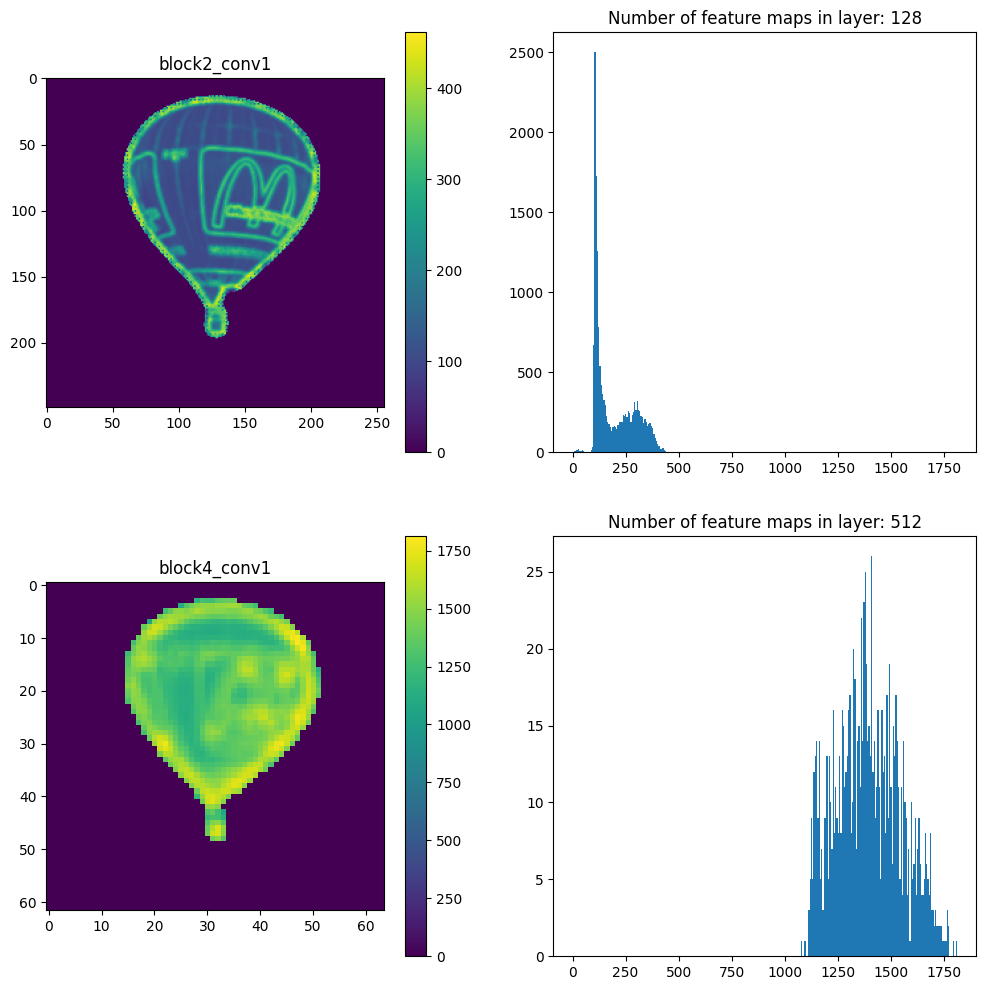

In [20]:
max_distance = 0
for distance_map in feature_distance_map.values():
  if distance_map.max() > max_distance:
    max_distance = distance_map.max()

for counter,(key, value) in enumerate(feature_distance_map.items()):
  
  plt.subplot(num_style_layers, 2, 2*counter +1)
  imshow(value, title=str(key))
  plt.colorbar()

  plt.subplot(num_style_layers, 2, 2*counter +2)
  plt.hist(value.ravel(), bins=300, range=(1e-3, max_distance))
  plt.title("Number of feature maps in layer: " 
            + str(style_neural_activations[str(key)].shape[-1]))

In [23]:
def print_layer_statistics(layer_dict, tensors=False):
  overall_mean = 0
  steps = 0
  for single_layer in layer_dict.items():
    print(single_layer[0])
    layer = single_layer[1]
    if not isinstance(layer, np.ndarray):
      layer = layer.numpy()

    print("Shape: {}".format(layer.shape))
    print("Min: {:.2f}".format(layer.min()))
    print("Mean: {:.2f}".format(layer.mean()))
    print("Max: {:.2f}".format(layer.max()))
    print("")

    steps +=1
    overall_mean += layer.mean()

  print("Total mean: {:.2f}".format(overall_mean/steps))

In [24]:
print_layer_statistics(input_to_style_mapping)

block2_conv1
Shape: (1, 249, 256, 128)
Min: 0.00
Mean: 272.71
Max: 4611.39

block4_conv1
Shape: (1, 62, 64, 512)
Min: 0.00
Mean: 745.55
Max: 20079.58

Total mean: 509.13


In [25]:
print_layer_statistics(gramatize(input_to_style_mapping))

block2_conv1
Shape: (1, 128, 128)
Min: 0.00
Mean: 83892.23
Max: 879109.38

block4_conv1
Shape: (1, 512, 512)
Min: 0.00
Mean: 574208.75
Max: 29157840.00

Total mean: 329050.49


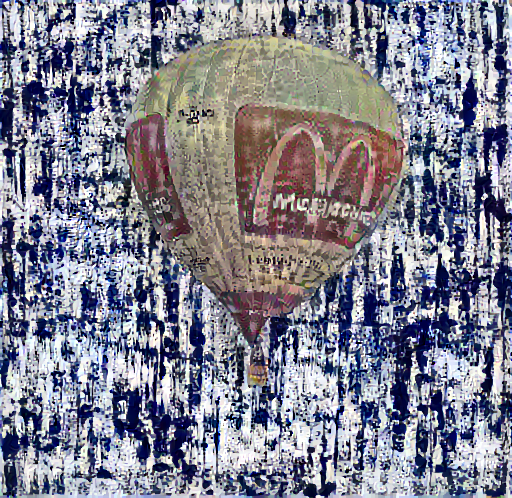

Gatys Reconstruction train step: 1000
Gatys Reconstruction time: 6400.7


In [26]:
# reconstruction weights
style_weight=1e-2 #1-e2
content_weight=1e4 #1e4
hist_weight = 1e4
total_variation_weight=30 #30 
     

# Definte the targets for the loss function
style_targets = gramatize(input_to_style_mapping) #G[P] in paper           
content_targets = neural_activation_model(input_image)['content_layers'] #F[I] in paper

intermediate_image = gatys_reconstruction(input_image)

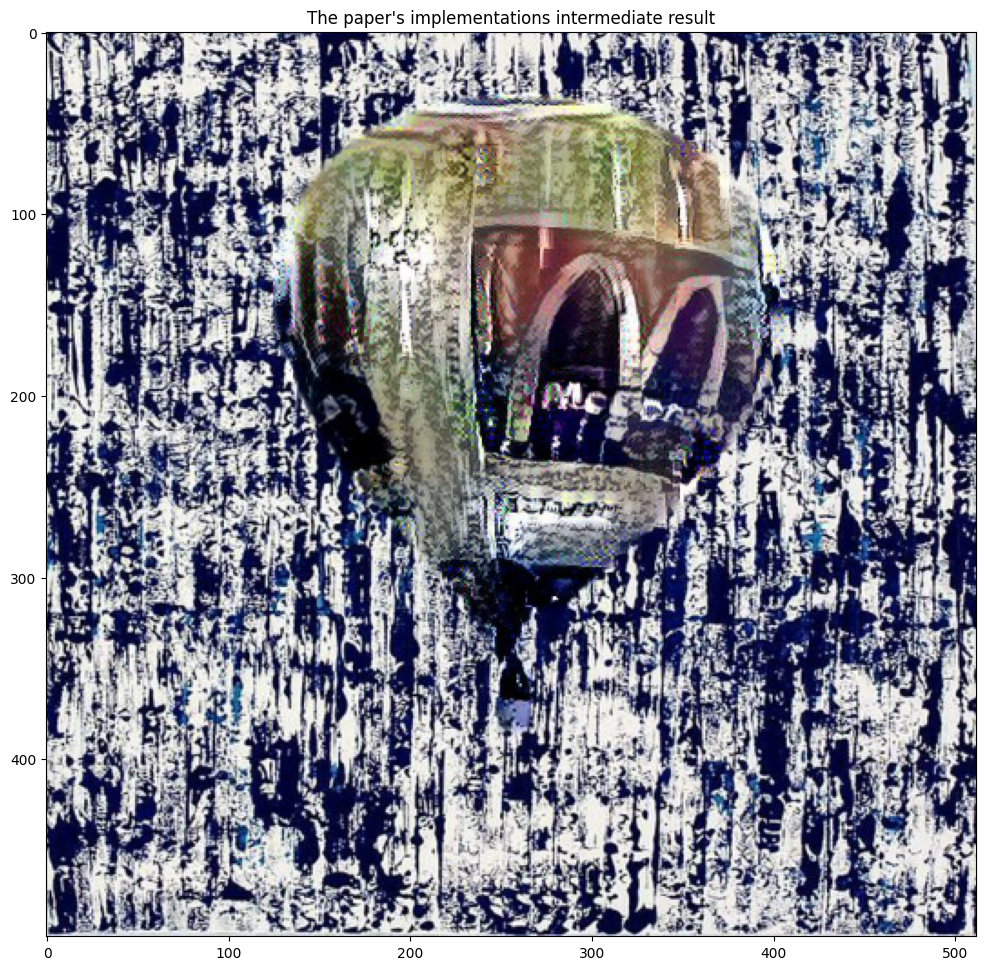

In [28]:
# For comparision, this is the official intermediate result
intermediate_official = load_img(intermediate_official_path)
imshow(intermediate_official, title="The paper's implementations intermediate result")

In [29]:
%tensorboard --logdir logs/first_pass

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 5396.

In [30]:
# Define our metrics
whole_loss_metric = tf.keras.metrics.Mean('whole_loss', dtype=tf.float32)
style_loss_metric = tf.keras.metrics.Mean('style_loss', dtype=tf.float32)
content_loss_metric = tf.keras.metrics.Mean('content_loss', dtype=tf.float32)
tv_loss_metric = tf.keras.metrics.Mean('tv_loss', dtype=tf.float32)
hist_loss_metric = tf.keras.metrics.Mean('hist_loss', dtype=tf.float32)

# Making metrics for each style layer
style_layers_tensorboard = {}
for layer_name in style_layers:
  metric = tf.keras.metrics.Mean(str(layer_name), dtype = tf.float32)
  style_layers_tensorboard[layer_name] = {'metric': metric}

# Making metrics for each hist layer
hist_layers_tensorboard = {}
for layer_name in hist_layers:
  metric = tf.keras.metrics.Mean(str(layer_name), dtype=tf.float32)
  hist_layers_tensorboard[layer_name] = {'metric': metric}
     

PASS = "second_pass"
current_time = datetime.datetime.now().strftime("%m%d-%H%M%S")

# Summary writers
style_log_dir = 'logs/second_pass/'+ current_time + str(IMAGE_SET)  + PASS+ '/style_loss'
tv_log_dir = 'logs/second_pass/'+ current_time + str(IMAGE_SET)  + PASS+ '/tv_loss'
content_log_dir = 'logs/second_pass/'+ current_time + str(IMAGE_SET)  + PASS+ '/content_loss'
hist_log_dir = 'logs/second_pass/' + current_time + str(IMAGE_SET) + PASS + '/hist_loss'
whole_loss_log_dir = 'logs/second_pass/'+ current_time + str(IMAGE_SET)  + PASS+ '/whole_loss'

style_summary_writer = tf.summary.create_file_writer(style_log_dir)
tv_summary_writer = tf.summary.create_file_writer(tv_log_dir)
content_summary_writer = tf.summary.create_file_writer(content_log_dir)
hist_loss_summary_writer = tf.summary.create_file_writer(hist_log_dir)
whole_loss_summary_writer = tf.summary.create_file_writer(whole_loss_log_dir)

# Making summary writer for each style layer
for layer_name in style_layers:
  log_dir = 'logs/second_pass/'+ current_time + str(IMAGE_SET)  + PASS + '/style_loss_of_' + str(layer_name)
  summary_writer = tf.summary.create_file_writer(log_dir)
  style_layers_tensorboard[layer_name]['summary_writer'] = summary_writer

# Making summary writer for each hist layer
for layer_name in hist_layers:
  log_dir = 'logs/second_pass/' + current_time + str(IMAGE_SET) + PASS + '/hist_loss_of_' + str(layer_name)
  summary_writer = tf.summary.create_file_writer(log_dir)
  hist_layers_tensorboard[layer_name]['summary_writer'] = summary_writer

In [31]:
def consistent_mapping(input_image_neural_activations, mask, style_neural_activations):

    print("\nProcessing consistent mapping with reference layer ", reference_layer)
    
    layers = input_image_neural_activations.keys()
    
    # initialize final mapping
    mapping_out = {}
    for layer_name in layers:
        mapping_out[layer_name] = {}
        
        # Size of feature map
        layer_height = input_image_neural_activations[layer_name].shape[1]
        layer_width = input_image_neural_activations[layer_name].shape[2]
        for i in range(layer_height):
            mapping_out[layer_name][i] = {}
            for j in range(layer_width):
                mapping_out[layer_name][i][j] = np.zeros((2))
  
    # input and style activations in reference layer
    # both have shape:  (1, height, width, number_of_feature_maps Nl)
    ref_input_image_layer_activation = all_output_activations['ref_layers'][reference_layer]
    ref_style_layer_activation = all_style_activations['ref_layers'][reference_layer]

    # Size of feature maps
    ref_input_height = ref_input_image_layer_activation.shape[1]
    ref_input_width = ref_input_image_layer_activation.shape[2]
    ref_style_height = ref_style_layer_activation.shape[1]
    ref_style_width = ref_style_layer_activation.shape[2]

    # Initialize mapping
    # For each input vector the mapping contains the i and j index of the mapped style vector
    nn_mapping = {}

    # Trim style_layer_activation so that its shape is completely divisible by PATCH_SIZE
    # TECHNICALLY, needed for nearest neighbor calculation
    ref_style_trimmed_height = ref_style_height - ref_style_height % PATCH_SIZE
    ref_style_trimmed_width = ref_style_width - ref_style_width % PATCH_SIZE
    ref_style_layer_activation = ref_style_layer_activation[:, :ref_style_trimmed_height, :ref_style_trimmed_width, :]

    # Resize mask to feature map size
    ref_mask = tf.image.resize(mask, (ref_input_height, ref_input_width))
    ref_mask = np.around(ref_mask)

    # 1.: Find nearest neighbor matches for reference layer
    print("Consistent Mapping step 1: Calculating nearest neighbor mapping for reference layer ", reference_layer, "...")

    # S1
    nn_used_indices = []
    
    # mapping
    for i in range(ref_input_height):
        print(int(i * 100 / ref_input_height), end="%, ")

        for j in range(ref_input_width):
            # Check if feature is inside mask
            if ref_mask[0, i, j, 0]:
        
                # cosidering 3x3 patch around the center for neares neighbor mapping
                input_patch = ref_input_image_layer_activation[:, i-P:i+P+1, j-P:j+P+1, :]

                nn_mapping[i, j] = find_nearest_neighbor(input_patch, ref_style_layer_activation)[1:]

    print("100%") 
    
    # 2.: Enforce spatial consistency
    print("Consistent Mapping step 2: Enforcing spatial consistency for reference layer ", reference_layer, "...")
    
    # offsets for moore neighborhood
    offsets = [
                    np.array([-1, -1]),   # NE
                    np.array([-1, 0]),    # E
                    np.array([-1, 1]),    # SE
                    np.array([0, -1]),    # N
                    np.array([0, 0]),     # center -> differs from paper, usefull for this implementation
                    np.array([0, 1]),     # S
                    np.array([1, -1]),    # NW
                    np.array([1, 0]),     # W
                    np.array([1, 1])      # SW
    ]

    for i in range(ref_input_height):
        print(int(i * 100 / ref_input_height), end="%, ")
        for j in range(ref_input_width):
            if ref_mask[0, i, j, 0]:

                # Find best candidate patch in moore neighborhood of the style activations
                
                # coordinates of the input patch p 
                p = np.array([i, j])
                
                # candidate patch style activations
                cset = []
                # collect all candidates 
                for o in offsets:
                    neighbor = p + o # neighbor of p in the input image
                    if not ref_mask[0, neighbor[0], neighbor[1], 0]:
                        # neighbor is not within the sticker, so there is no style mapping for this neighbor patch
                        continue
                    neighbors_style = np.array(nn_mapping[neighbor[0], neighbor[1]])  # mapped style patch for the neighbor
                    c = neighbors_style - o
                    cset.append(c)
                
                # calculate each candidate's error
                errors = []
                for c in cset:
                    error = 0
                    c_activation = ref_style_layer_activation[:, c[0], c[1], :]
                    #summation_steps = 0
                    for o in offsets: 
                        neighbor = p + o
                        if not ref_mask[0, neighbor[0], neighbor[1], 0]:
                            # neighbor is not within the sticker, so there is no style mapping for this neighbor patch
                            continue
                        #summation_steps += 1
                        neighbors_style = nn_mapping[neighbor[0], neighbor[1]]
                        neighbors_style_activation = ref_style_layer_activation[: , neighbors_style[0], neighbors_style[1], :]
                        error += tf.norm(c_activation - neighbors_style_activation)
                    
                    #error /= summation_steps
                    errors.append(error)
                
                # choose the candidate with the minimal error
                # use the fact that cset and errors have the same indexing
                chosen_index = np.argmin(np.array(errors))
                chosen = cset[chosen_index]

                # TODO: visualize feature map with minimum error highlighted
                # but how...?
                
                # update mapping
                mapping_out[reference_layer][i][j] = chosen

    print("100%")
    
    # 3.: Propagate the matches in the reference layer to the other layers
    
    # Size of style feature map of the reference layer
    ref_style_height = ref_style_layer_activation.shape[1]
    ref_style_width = ref_style_layer_activation.shape[2]
    
    print("Consistent Mapping Step 3: Propagating matches for reference layer to other layers...")
    
    remapped = {}
    for layer_name in layers:
        
        # both have shape:  (1, height, width, number_of_feature_maps Nl)
        l_input_image_layer_activation = input_image_neural_activations[layer_name]
        l_style_layer_activation = style_neural_activations[layer_name]
        
        # Size of input feature map
        l_input_height = l_input_image_layer_activation.shape[1]
        l_input_width = l_input_image_layer_activation.shape[2]
        
        # Size of style feature map
        l_style_height = l_style_layer_activation.shape[1]
        l_style_width = l_style_layer_activation.shape[2]
        
        # Trim style_layer_activation so that its shape is completely divisible by PATCH_SIZE
        # TECHNICALLY
        #l_trimmed_height = l_input_height - l_input_height % PATCH_SIZE
        #l_trimmed_width = l_input_width - l_input_width % PATCH_SIZE
        l_style_layer_activation = l_style_layer_activation[:, :l_style_height, :l_style_width, :]
        
        # Resize mask to feature map
        l_mask = tf.image.resize(mask, (l_input_height, l_input_width))
        l_mask = np.around(l_mask)
        
        if layer_name is not reference_layer:
            
            print("Propagating matches for reference layer to layer ", layer_name)
  
            for i in range(l_input_height):
                for j in range(l_input_width):
                    if l_mask[0, i, j, 0]:
                        # calculate 

                        # p' are feature coordinates in the input image
                        l_i = int(np.around((i * ref_input_height) / l_input_height))
                        l_j = int(np.around((j * ref_input_width) / l_input_width))
                        
                        # Fetch matching style patch in the reference layer
                        # q are feature coordinates in the style image
                        q = mapping_out[reference_layer][l_i][l_j]
                        q_i = q[0]
                        q_j = q[1]
                        
                        # Change resolution back 
                        update_i = np.around((q_i * l_style_height) / ref_style_height)
                        update_j = np.around((q_j * l_style_width) / ref_style_width)
                        
                        # Update mapping for this layer
                        mapping_out[layer_name][i][j][0] = update_i
                        mapping_out[layer_name][i][j][1] = update_j
            
        # apply mapping
        remapped[layer_name] = np.copy(l_input_image_layer_activation)
        for i in range(l_input_height):
            for j in range(l_input_width):
                if l_mask[0, i, j, 0]:
                    # mapping from p to q
                    # p is in the input image activations, q is in the style image activations
                    q_i = int(mapping_out[layer_name][i][j][0])
                    q_j = int(mapping_out[layer_name][i][j][1])
                    remapped[layer_name][:, i, j, :] = l_style_layer_activation[:, q_i, q_j, :]    

    
    print("Consistent mapping finished!")
    return mapping_out, remapped, nn_mapping

In [32]:
def hist_loss(outputs):
    from scipy.interpolate import interp1d
    from scipy.optimize import fsolve
    num_bins = 256
    decimals = 2 # used for activation mapping
    hist_outputs = outputs['hist_layers']
    hist_loss = 0

    # histogram matching
    r = {}  # histogram targets R[O]
    for layer_name in hist_layers:

        output_activations = hist_outputs[layer_name]
        style_activations = all_style_activations['hist_layers'][layer_name]
        max_val = np.amax([np.amax(output_activations), np.amax(style_activations)])
        value_range = tf.constant([0, max_val], dtype=tf.float32)
        bin_size = max_val / num_bins
        bin_mean = bin_size / 2

        # output histogram
        output_histogram = tf.histogram_fixed_width(output_activations, 
                                                    value_range, 
                                                    nbins=num_bins)
        # mapping from output activation to bin
        output_to_bin = tf.histogram_fixed_width_bins(output_activations, 
                                                    value_range, 
                                                    nbins=num_bins)
        print("Calculated output histogram for layer", layer_name, ".")

        # cumulative distribution function over output activations
        num_output_activations = np.prod(output_activations.shape)
        output_cdf = tf.cumsum(output_histogram) / num_output_activations
        print("Calculated cumulative distribution function over output activations for layer", layer_name, ".")

        # style histogram
        style_histogram = tf.histogram_fixed_width(style_activations, 
                                                   value_range, 
                                                   nbins=num_bins)
        print("Claculated style histogram for layer", layer_name, ".")
        num_style_activations = np.prod(style_activations.shape)
        # cumulative distribution function over style activations
        style_cdf = tf.cumsum(style_histogram) / num_style_activations
        print("Calculated cumulative distribution function over style activations for layer", layer_name, ".")
        
         
        # plot cdfs
        print("Plotting CDFs for layer", layer_name, ":")
        plt.plot(output_cdf)
        plt.plot(style_cdf)
        plt.ylabel('CDF')
        plt.xlabel('Bin')
        plt.legend(["Output", "Style"])
        plt.show()

        """
        # map unambiguously from bin to style activation
        # hard way: take average of all elements in that bin as activation do be applied
        # easier way: take average of bin's range (chosen atm)
        # another idea: Get the cdf as a continuous function f(a) while a is the activation value. 
        # This would provide an unambiguous mapping funciton! => how?!
        hist_mapping = {}
        for i in range(num_bins):
            # map vectors with smallest difference in probability
            hist_mapping[i] = np.argmin(np.abs(style_cdf - output_cdf[i]))
        print("Completed histogram mapping for layer", layer_name, ".")
        
        # for simplification assign mean of bin range instead of mean of bin members
        bin_to_activation = {}    
        bin_size = max_val / num_bins
        bin_mean = bin_size / 2.
        for bin_nr in range(num_bins):
            bin_to_activation[bin_nr] = bin_size * bin_nr + bin_mean
        
        # remap to get 

        print("Remapping output, generating R_l[O] for layer", layer_name, ".")
        r[layer_name] = np.zeros(output_activations.shape)
        for i in range(output_activations.shape[1]):
            for j in range(output_activations.shape[2]):
                for k in range(output_activations.shape[3]):
                    output_bin = output_to_bin[0, i, j, k].numpy()
                    style_bin = hist_mapping[output_bin]
                    style_activation = bin_to_activation[style_bin]
                    r[layer_name][:, i, j, k] = style_activation
        """
        
        # unambiguous mapping from output activation to style activation

        interp_x = np.zeros(num_bins)

        # continuous cdf over real activation values
        for i in range(num_bins):
            interp_x[i] = bin_size * i + bin_mean * (i > 0)
        interp_y = output_cdf.numpy()
        output_cdf_cont = interp1d(interp_x, interp_y, bounds_error=False, fill_value="extrapolate")
        
        # continuous cdf over real activation values
        interp_y = style_cdf.numpy()
        style_cdf_cont = interp1d(interp_x, interp_y, bounds_error=False, fill_value="extrapolate")
        
        # create mapping from output activation to style activation by solving 

        # round activations for performance
        unique_output = np.unique(np.around(output_activations, decimals))
        print("Calculating histogram mapping over", unique_output.shape[0], "unique values.")
        hist_mapping = {}
        for x1 in unique_output:
            def root_eq(x2):
                return output_cdf_cont(x1) - style_cdf_cont(x2)
            # solve F1(x1) - F2(x2) = 0 | x1 is constant 
            hist_mapping[x1] = fsolve(root_eq, x1)
        
        # remap to get 

        # TODO: change output number of activations to be remapped: only within mask 
        print("Remapping output, generating R_l[O] for layer", layer_name, ". There are", num_output_activations, "values to be remapped.")
        r[layer_name] = np.zeros(output_activations.shape)
        # only remap feature vectors within mask
        #l_mask = tf.image.resize(mask, (output_activations.shape[1], output_activations.shape[2]))
        #l_mask = np.around(l_mask)
        for i in range(output_activations.shape[1]):
            for j in range(output_activations.shape[2]):
                #if l_mask[0, i, j, 0]:
                    for k in range(output_activations.shape[3]):
                        r[layer_name][:, i, j, k] = hist_mapping[np.around(output_activations[0, i, j, k].numpy(), decimals)]

        
    # Calculate real histogram loss
    print("Remapping finished. Claculating loss.")
    hist_loss += tf.add_n([tf.reduce_mean((hist_outputs[name] - r[name]) ** 2) 
                           for name in hist_layers])
    hist_loss *= hist_weight / num_hist_layers
    print("Histogram loss calculated.")
    
    return hist_loss

In [33]:
def style_loss(outputs):
    # TODO: what is S1 loss?
    style_outputs = gramatize(outputs['style_layers'])
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-gram_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    style_loss_metric(style_loss)

    return style_loss
     

def content_loss(outputs):
    content_outputs = outputs['content_layers']
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers

    content_loss_metric(content_loss)
    
    return content_loss
     

def tv_loss(image):
    return total_variation_weight * tf.image.total_variation(image)
     

#@tf.function()
def final_train_step(image, hist=False):
    with tf.GradientTape() as tape:
        outputs = neural_activation_model(image)
        # hist loss needs far too many computing time
        tv_loss_val = tv_loss(image)
        loss = content_loss(outputs) + style_loss(outputs) + tv_loss_val
        if (hist):
            hist_loss_val = hist_loss(outputs)
            loss += hist_loss_val

        # Fill metrics for Tensorboard
        tv_loss_metric(tv_loss_val)
        if (hist):
            hist_loss_metric(hist_loss_val)
        whole_loss_metric(loss)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))
     

#test hist loss
#image = tf.Variable(intermediate_official)
#style_neural_activations = neural_activation_model(style_image)['hist_layers']
#outputs = neural_activation_model(image)
#loss = hist_loss(outputs)
     

def final_reconstruct(output_image):
    output_image = tf.Variable(output_image)

    import time
    start = time.time()

    step = 0
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            #do_hist = step % 100 is 0
            do_hist = False
            final_train_step(output_image, hist=do_hist)
            print(".", end="")

            # Tensorboard stuff
            with content_summary_writer.as_default():
                tf.summary.scalar('Loss', content_loss_metric.result(), step=step)
            content_loss_metric.reset_states()

            with style_summary_writer.as_default():
                tf.summary.scalar('Loss', style_loss_metric.result(), step=step)
            style_loss_metric.reset_states()

            if do_hist:
                with hist_loss_summary_writer.as_default():
                    tf.summary.scalar('Loss', hist_loss_metric.result(), step=step)
                hist_loss_metric.reset_states()

            with tv_summary_writer.as_default():
                tf.summary.scalar('Loss', tv_loss_metric.result(), step=step)
            tv_loss_metric.reset_states()

            with whole_loss_summary_writer.as_default():
                tf.summary.scalar('Loss', whole_loss_metric.result(), step=step)
            whole_loss_metric.reset_states()
            
        print("Final reconstruction train step: {}".format(step))

        # Put the image to tensorboard
        with whole_loss_summary_writer.as_default():
          tf.summary.image("Output image", output_image, step=step)

    end = time.time()
    print("Final reconstruction time: {:.1f}".format(end-start))
    return output_image

In [34]:
# Second Pass
print("Starting second pass...")
print('')

# Only the neural activations of the layers used for the style are important for the independent mapping
all_style_activations = neural_activation_model(style_image)
# TODO: change to own intermediate
all_output_activations = neural_activation_model(intermediate_image)
mapping_input_activations = all_output_activations['style_layers']
mapping_input_activations.update(all_output_activations['ref_layers'])
mapping_style_activations = all_style_activations['style_layers']
mapping_style_activations.update(all_style_activations['ref_layers'])

input_to_style_mapping, remapped_targets, nn_ref_mapping = consistent_mapping(mapping_input_activations, 
                                            mask_image, 
                                            mapping_style_activations)

gram_targets = gramatize(remapped_targets)

Starting second pass...


Processing consistent mapping with reference layer  block4_conv1
Consistent Mapping step 1: Calculating nearest neighbor mapping for reference layer  block4_conv1 ...
0%, 1%, 3%, 4%, 6%, 8%, 9%, 11%, 12%, 14%, 16%, 17%, 19%, 20%, 22%, 24%, 25%, 27%, 29%, 30%, 32%, 33%, 35%, 37%, 38%, 40%, 41%, 43%, 45%, 46%, 48%, 50%, 51%, 53%, 54%, 56%, 58%, 59%, 61%, 62%, 64%, 66%, 67%, 69%, 70%, 72%, 74%, 75%, 77%, 79%, 80%, 82%, 83%, 85%, 87%, 88%, 90%, 91%, 93%, 95%, 96%, 98%, 100%
Consistent Mapping step 2: Enforcing spatial consistency for reference layer  block4_conv1 ...
0%, 1%, 3%, 4%, 6%, 8%, 9%, 11%, 12%, 14%, 16%, 17%, 19%, 20%, 22%, 24%, 25%, 27%, 29%, 30%, 32%, 33%, 35%, 37%, 38%, 40%, 41%, 43%, 45%, 46%, 48%, 50%, 51%, 53%, 54%, 56%, 58%, 59%, 61%, 62%, 64%, 66%, 67%, 69%, 70%, 72%, 74%, 75%, 77%, 79%, 80%, 82%, 83%, 85%, 87%, 88%, 90%, 91%, 93%, 95%, 96%, 98%, 100%
Consistent Mapping Step 3: Propagating matches for reference layer to other layers...
Propagatin

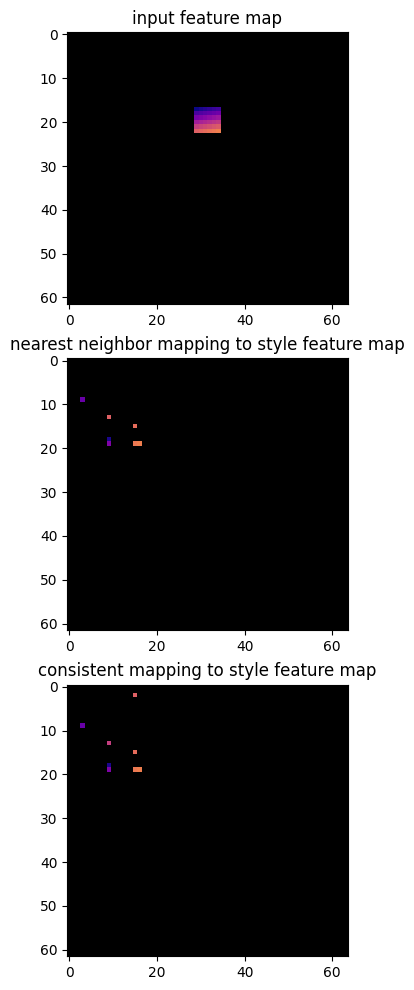

In [35]:
# visualize part of input to style mapping
layer_mapping = input_to_style_mapping[reference_layer]
map_height = mapping_input_activations[reference_layer].shape[1]
map_width = mapping_input_activations[reference_layer].shape[2]
input_map_vis = np.zeros((map_height, map_width, 3))
style_nn_map_vis = np.zeros((map_height, map_width, 3))
style_map_vis = np.zeros((map_height, map_width, 3))

# create color map for colorization
from matplotlib import cm
# quadratic number of activations to display
n_activations = 49
display_offset = int(np.sqrt(n_activations) / 2)
colors = np.zeros((n_activations, 3))
color_map = np.array(cm.get_cmap('plasma').colors)
step = int((len(color_map)-1) / (n_activations-1))
for activation_i in range(n_activations):
  for rgb_channel in range(3):
    colors[activation_i, rgb_channel] = color_map[step * activation_i, rgb_channel]

activation_i = 0
for i in range(int(map_height/3 - display_offset) , int(map_height/3 + display_offset)):
  for j in range(int(map_width/2 - display_offset), int(map_width/2 + display_offset)):
    color = colors[activation_i]
    activation_i += 1
    input_map_vis[i, j] = color
    q_nn = nn_ref_mapping[i,j]
    style_nn_map_vis[int(q_nn[0]), int(q_nn[1])] = color
    q = layer_mapping[i][j]
    style_map_vis[int(q[0]), int(q[1])] = color

plt.subplot(311)
imshow(input_map_vis, title="input feature map")
plt.subplot(312)
imshow(style_nn_map_vis, title="nearest neighbor mapping to style feature map")
plt.subplot(313)
imshow(style_map_vis, "consistent mapping to style feature map")
plt.show()

In [39]:
final_image = final_reconstruct(intermediate_image)

....................................................................................................Final reconstruction train step: 100
....................................................................................................Final reconstruction train step: 200
....................................................................................................Final reconstruction train step: 300
....................................................................................................Final reconstruction train step: 400
....................................................................................................Final reconstruction train step: 500
....................................................................................................Final reconstruction train step: 600
....................................................................................................Final reconstruction train step: 700
.........................................

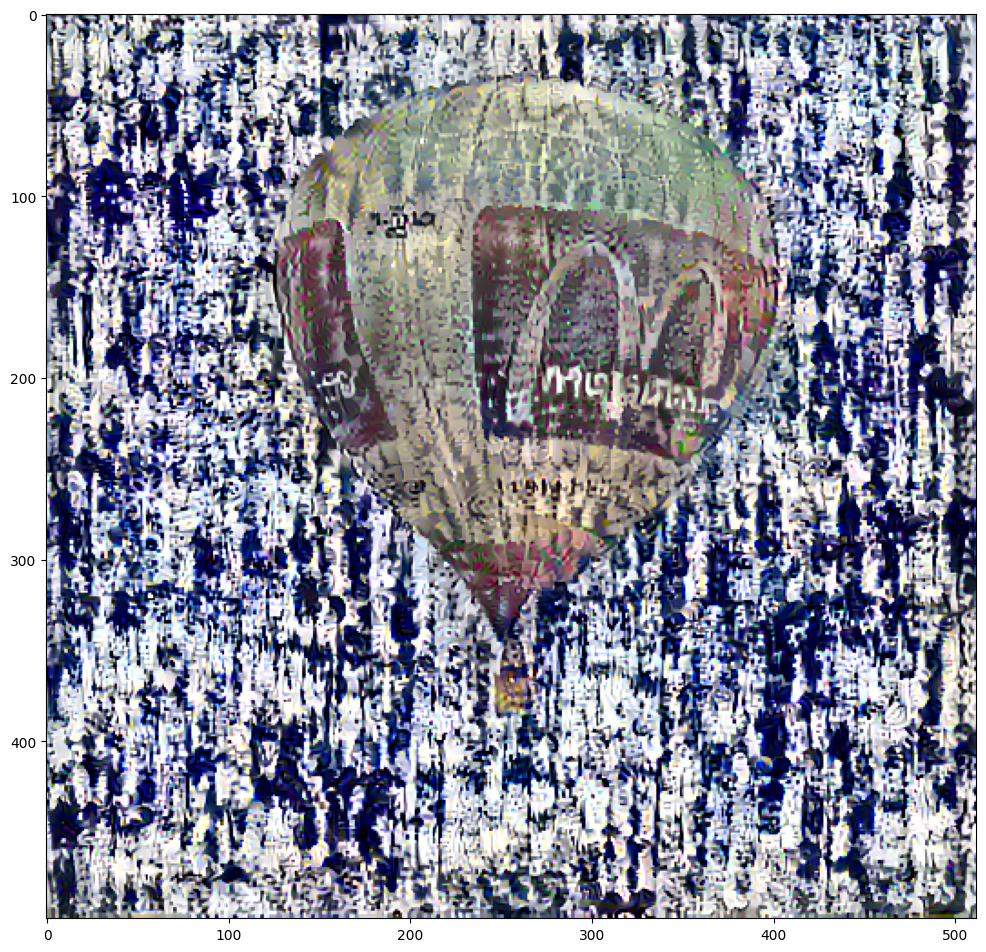

In [40]:
imshow(final_image)

In [41]:
%tensorboard --logdir logs/second_pass/